In [85]:
import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

In [86]:
train = pd.read_csv('C:/Users/tmdwh/Desktop/SEUNGJO/dacon/competition_data/train.csv')
test = pd.read_csv('C:/Users/tmdwh/Desktop/SEUNGJO/dacon/competition_data/test.csv')
submission = pd.read_csv('C:/Users/tmdwh/Desktop/SEUNGJO/dacon/competition_data/submission.csv', index_col = 0)

In [87]:
train.fillna(0, inplace = True)
test.fillna(0, inplace = True)

In [88]:
drop_list = ['introelapse', 'testelapse', 'surveyelapse', 'index']

train.drop(drop_list, axis = 1, inplace = True)
test.drop(drop_list, axis = 1, inplace = True)

In [89]:
# fillna(0) -> 0으로 채운 값들을 평균 값으로 처리
processing_feature = ['gender', 'married', 'education', 'voted', 'urban', 'orientation', 'religion', 'engnat', 'ASD']

for pro in processing_feature:
    train.loc[train[pro] == 0, pro] = train[pro].mean()
    test.loc[test[pro] == 0, pro] = train[pro].mean()

In [90]:
#age 이상치(80살 이상) 0으로 처리
train.loc[train['age'] > 80, 'age'] = 0
test.loc[test['age'] > 80, 'age'] = 0

In [91]:
#age의 이상치는 train데이터의 평균값으로 처리
train.loc[train['age'] == 0, 'age'] = train['age'].mean()
test.loc[test['age'] == 0, 'age'] = train['age'].mean()

#familysize 6 이상인 값 최빈값으로 교체, 
train.loc[train['familysize'] > 6, 'familysize'] = train['familysize'].mode()[0]
test.loc[test['familysize'] > 6, 'familysize'] = train['familysize'].mode()[0]

In [92]:
#훈련 데이터에 존재하는 상위 6개의 나라
best6_country = train['country'].value_counts().keys()[:6]

#train데이터 상위 6개 국가 제외 train데이터의 최빈값으로 처리
for i in range(len(train['country'])):
    if train['country'][i] not in best6_country or train['country'][i]==0:
        train['country'][i] = train['country'].mode()[0]

#test데이터 상위 6개 국가 제외 train데이터의 최빈값으로 처리
for i in range(len(test['country'])):
    if test['country'][i] not in best6_country or test['country'][i]==0:
        test['country'][i] = train['country'].mode()[0]

In [93]:
#country 특성 원-핫인코딩 수행 (country 특성 세부 분할)
train = pd.get_dummies(train)
test = pd.get_dummies(test)

In [94]:
train.columns


Index(['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11',
       'Q12', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17', 'Q18', 'Q19', 'Q20', 'Q21',
       'Q22', 'Q23', 'Q24', 'Q25', 'Q26', 'TIPI1', 'TIPI2', 'TIPI3', 'TIPI4',
       'TIPI5', 'TIPI6', 'TIPI7', 'TIPI8', 'TIPI9', 'TIPI10', 'VCL1', 'VCL2',
       'VCL3', 'VCL4', 'VCL5', 'VCL6', 'VCL7', 'VCL8', 'VCL9', 'VCL10',
       'VCL11', 'VCL12', 'VCL13', 'VCL14', 'VCL15', 'VCL16', 'education',
       'urban', 'gender', 'engnat', 'age', 'hand', 'religion', 'orientation',
       'voted', 'married', 'familysize', 'ASD', 'nerdiness', 'country_AUS',
       'country_CAN', 'country_DEU', 'country_GBR', 'country_PHL',
       'country_USA'],
      dtype='object')

In [95]:
train.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,married,familysize,ASD,nerdiness,country_AUS,country_CAN,country_DEU,country_GBR,country_PHL,country_USA
0,1.0,5.0,5.0,5.0,1.0,4.0,5.0,5.0,1.0,3.0,...,1.0,4.0,2.0,1,0,0,0,0,0,1
1,4.0,4.0,4.0,4.0,4.0,5.0,4.0,4.0,3.0,3.0,...,2.0,4.0,2.0,1,0,0,0,0,0,1
2,4.0,5.0,5.0,4.0,3.0,5.0,5.0,5.0,4.0,4.0,...,3.0,4.0,2.0,1,0,0,0,0,0,1
3,4.0,4.0,4.0,2.0,4.0,3.0,3.0,5.0,3.0,4.0,...,1.0,2.0,2.0,1,0,0,0,0,0,1
4,4.0,4.0,4.0,4.0,3.0,3.0,4.0,2.0,3.0,4.0,...,1.0,1.0,2.0,0,0,0,0,0,0,1


In [96]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 71 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Q1           15000 non-null  float64
 1   Q2           15000 non-null  float64
 2   Q3           15000 non-null  float64
 3   Q4           15000 non-null  float64
 4   Q5           15000 non-null  float64
 5   Q6           15000 non-null  float64
 6   Q7           15000 non-null  float64
 7   Q8           15000 non-null  float64
 8   Q9           15000 non-null  float64
 9   Q10          15000 non-null  float64
 10  Q11          15000 non-null  float64
 11  Q12          15000 non-null  float64
 12  Q13          15000 non-null  float64
 13  Q14          15000 non-null  float64
 14  Q15          15000 non-null  float64
 15  Q16          15000 non-null  float64
 16  Q17          15000 non-null  float64
 17  Q18          15000 non-null  float64
 18  Q19          15000 non-null  float64
 19  Q20 

In [97]:
# 마키아벨리즘에 대한 질문 점수
makia_survey = ['Q' + str(i+1) for i in range(20)]
not_makia = ['Q3', 'Q4', 'Q6','Q7', 'Q9', 'Q10', 'Q11', 'Q14', 'Q16', 'Q17', 'Q18']
# 'Q6', 'Q14', 'Q18'
# 'Q21', 'Q22', 'Q23', 'Q23', 'Q24', 'Q25', 'Q26'은 secret question이라 제외

for columns in not_makia:
    train.loc[train[columns] > 0, columns] = 6 - train[columns]
    test.loc[test[columns] > 0, columns] = 6 - test[columns]



# 기준치 (60점 이상)에 관련된 파생변수 생성
train['makia_score'] = np.sum(train[makia_survey], axis = 1)
test['makia_score'] = np.sum(test[makia_survey], axis = 1)

train['high_makia'] = train['makia_score'].apply(lambda x : (1 if x > 60 else 0))
test['high_makia'] = test['makia_score'].apply(lambda x : (1 if x > 60 else 0))

In [98]:
'''
 TIPI에 대한 질문 점수
 TIPI는 1 ~ 7점까지 존재 -> 1 ~ 5점으로 변환
 TIPI 1점 -> 1점
 TIPI 2점 -> 2점
 TIPI 3점 -> 3점
 TIPI 4점 -> 3점
 TIPI 5점 -> 3점
 TIPI 6점 -> 4점 
 TIPI 7점 -> 5점
'''
TIPI_columns = ['TIPI' + str(x + 1) for x in range(10)]
TIPI_score = {1:1, 2:2, 3:4, 3:5, 4:6, 5:7}


for tipi in TIPI_columns:
    train[tipi] = train[tipi].map(TIPI_score)
    test[tipi] = test[tipi].map(TIPI_score)

train[TIPI_columns].describe()

,TIPI1,TIPI2,TIPI3,TIPI4,TIPI5,TIPI6,TIPI7,TIPI8,TIPI9,TIPI10
count,14947.000000,14934.000000,14921.000000,14936.000000,14930.000000,14938.000000,14936.000000,14935.000000,14936.000000,14920.000000
mean,3.746839,4.561470,5.230615,4.850696,5.799062,5.465390,5.314140,4.518581,4.738551,3.002212
std,2.056801,1.805834,1.504850,1.874021,1.141452,1.593373,1.490199,1.908174,1.763865,1.948030
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,2.000000,5.000000,1.000000
50%,5.000000,5.000000,5.000000,5.000000,6.000000,6.000000,5.000000,5.000000,5.000000,2.000000
75%,5.000000,6.000000,6.000000,6.000000,7.000000,7.000000,6.000000,6.000000,6.000000,5.000000
max,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000


In [99]:
'''
TIPI 관련 파생변수 생성

성실성 : {3번 점수 + (8 - '8번 점수')} ÷ 2
우호성 : {7번 점수 + (8 - '2번 점수')} ÷ 2
정서적 안정성(점수가 낮으면 신경성과 관련): {9번 점수 + (8 - '4번 점수')} ÷ 2
개방성 : {5번 점수 + (8 - '10번 점수')} ÷ 2
외향성 : {1번 점수 + (8 - '6번 점수')} ÷ 2
'''

train['diligence'] = (train['TIPI3'] + 8 - train['TIPI8']) / 2
train['friendliness'] = (train['TIPI7'] + 8- train['TIPI2']) / 2
train['stability'] = (train['TIPI9'] + 8 - train['TIPI4']) / 2
train['openness'] = (train['TIPI5'] + 8 - train['TIPI10']) / 2
train['extroversion'] = (train['TIPI1'] + 8 - train['TIPI6']) / 2


test['diligence'] = (test['TIPI3'] + 8 - test['TIPI8']) / 2
test['friendliness'] = (test['TIPI7'] + 8- test['TIPI2']) / 2
test['stability'] = (test['TIPI9'] + 8 - test['TIPI4']) / 2
test['openness'] = (test['TIPI5'] + 8 - test['TIPI10']) / 2
test['extroversion'] = (test['TIPI1'] + 8 - test['TIPI6']) / 2

In [100]:
# EDA 결과 50대 이상일수록 nerdiness가 1인 비율이 많아짐. => 관련 파생변수 생성
# children = 1
# adult = 2
# middle age = 3
# old age = 4
def age_to_category(age):
    normalize = age // 10
    if normalize == 1:
        return 'children'
    elif (normalize >= 2) & (normalize <= 3):
        return 'adult'
    elif (normalize >= 4) & (normalize <= 6):
        return 'middle age'
    else:
        return 'old age'

In [101]:
train.columns

Index(['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11',
       'Q12', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17', 'Q18', 'Q19', 'Q20', 'Q21',
       'Q22', 'Q23', 'Q24', 'Q25', 'Q26', 'TIPI1', 'TIPI2', 'TIPI3', 'TIPI4',
       'TIPI5', 'TIPI6', 'TIPI7', 'TIPI8', 'TIPI9', 'TIPI10', 'VCL1', 'VCL2',
       'VCL3', 'VCL4', 'VCL5', 'VCL6', 'VCL7', 'VCL8', 'VCL9', 'VCL10',
       'VCL11', 'VCL12', 'VCL13', 'VCL14', 'VCL15', 'VCL16', 'education',
       'urban', 'gender', 'engnat', 'age', 'hand', 'religion', 'orientation',
       'voted', 'married', 'familysize', 'ASD', 'nerdiness', 'country_AUS',
       'country_CAN', 'country_DEU', 'country_GBR', 'country_PHL',
       'country_USA', 'makia_score', 'high_makia', 'diligence', 'friendliness',
       'stability', 'openness', 'extroversion'],
      dtype='object')

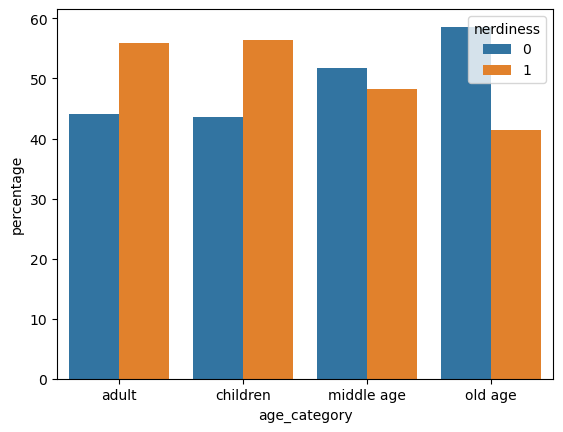

In [102]:
train['age_category'] = train['age'].apply(lambda x : age_to_category(x))
counts = train.groupby('age_category')['nerdiness'].value_counts(normalize = True).rename('percentage').mul(100).reset_index()
sns.barplot(x = 'age_category', y = 'percentage', hue = 'nerdiness', data = counts)
test['age_category'] = test['age'].apply(lambda x : age_to_category(x))


In [103]:
#country 특성 원-핫인코딩 수행 (country 특성 세부 분할)
train = pd.get_dummies(train)
test = pd.get_dummies(test)

train.columns

Index(['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11',
       'Q12', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17', 'Q18', 'Q19', 'Q20', 'Q21',
       'Q22', 'Q23', 'Q24', 'Q25', 'Q26', 'TIPI1', 'TIPI2', 'TIPI3', 'TIPI4',
       'TIPI5', 'TIPI6', 'TIPI7', 'TIPI8', 'TIPI9', 'TIPI10', 'VCL1', 'VCL2',
       'VCL3', 'VCL4', 'VCL5', 'VCL6', 'VCL7', 'VCL8', 'VCL9', 'VCL10',
       'VCL11', 'VCL12', 'VCL13', 'VCL14', 'VCL15', 'VCL16', 'education',
       'urban', 'gender', 'engnat', 'age', 'hand', 'religion', 'orientation',
       'voted', 'married', 'familysize', 'ASD', 'nerdiness', 'country_AUS',
       'country_CAN', 'country_DEU', 'country_GBR', 'country_PHL',
       'country_USA', 'makia_score', 'high_makia', 'diligence', 'friendliness',
       'stability', 'openness', 'extroversion', 'age_category_adult',
       'age_category_children', 'age_category_middle age',
       'age_category_old age'],
      dtype='object')

In [45]:
# 특정 종교와 관련하여 nerdiness 변화가 뚜렷함.
def convert_environment(x):
    if ((x == '2.0') | (x == '5.0') | (x == '9.0')):
        return 0
    elif ((x == '1.0') | (x == '12.0') | (x == '6.0') | (x == '7.0')):
        return 1
    else:
        return 2


train['religion_environment'] = train['religion'].apply(lambda x : convert_environment(x))
test['religion_environment'] = test['religion'].apply(lambda x : convert_environment(x))

In [46]:
# age, religion -> 삭제
train.drop(['age', 'religion'], axis = 1, inplace = True)
test.drop(['age', 'religion'], axis = 1, inplace = True)

In [56]:
#country 특성 원-핫인코딩 수행 (country 특성 세부 분할)
train = pd.get_dummies(train)
test = pd.get_dummies(test)


In [57]:
train.columns

Index(['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11',
       'Q12', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17', 'Q18', 'Q19', 'Q20', 'Q21',
       'Q22', 'Q23', 'Q24', 'Q25', 'Q26', 'TIPI1', 'TIPI2', 'TIPI3', 'TIPI4',
       'TIPI5', 'TIPI6', 'TIPI7', 'TIPI8', 'TIPI9', 'TIPI10', 'VCL1', 'VCL2',
       'VCL3', 'VCL4', 'VCL5', 'VCL6', 'VCL7', 'VCL8', 'VCL9', 'VCL10',
       'VCL11', 'VCL12', 'VCL13', 'VCL14', 'VCL15', 'VCL16', 'education',
       'urban', 'gender', 'engnat', 'hand', 'orientation', 'voted', 'married',
       'familysize', 'ASD', 'nerdiness', 'country_AUS', 'country_CAN',
       'country_DEU', 'country_GBR', 'country_PHL', 'country_USA',
       'makia_score', 'high_makia', 'diligence', 'friendliness', 'stability',
       'openness', 'extroversion', 'age_category_adult',
       'age_category_children', 'age_category_middle age',
       'age_category_old age', 'religion_environment_3'],
      dtype='object')

In [58]:
!pip install --quiet optuna

In [59]:
import numpy as np
import pandas as pd
import optuna
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from optuna.samplers import TPESampler
from optuna.pruners import SuccessiveHalvingPruner

In [60]:
features = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11',
       'Q12', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17', 'Q18', 'Q19', 'Q20', 'Q21',
       'Q22', 'Q23', 'Q24', 'Q25', 'Q26', 'TIPI1', 'TIPI2', 'TIPI3', 'TIPI4',
       'TIPI5', 'TIPI6', 'TIPI7', 'TIPI8', 'TIPI9', 'TIPI10', 'VCL1', 'VCL2',
       'VCL3', 'VCL4', 'VCL5', 'VCL6', 'VCL7', 'VCL8', 'VCL9', 'VCL10',
       'VCL11', 'VCL12', 'VCL13', 'VCL14', 'VCL15', 'VCL16', 'education',
       'urban', 'gender', 'engnat', 'hand', 'orientation', 'voted', 'married',
       'familysize', 'ASD', 'country_AUS', 'country_CAN',
       'country_DEU', 'country_GBR', 'country_PHL', 'country_USA',
       'makia_score', 'high_makia', 'diligence', 'friendliness', 'stability',
       'openness', 'extroversion', 'age_category_adult',
       'age_category_children', 'age_category_middle age',
       'age_category_old age', 'religion_environment_3']

target = ['nerdiness']

In [61]:
df_trains = []
df_valids = []

skf = StratifiedKFold(n_splits=10, random_state=2022, shuffle=True)
for train_index, valid_index in skf.split(train[features], train[target]):
    df_train = train.loc[train_index]
    df_valid = train.loc[valid_index]
    df_trains.append(df_train)
    df_valids.append(df_valid)

    x_train = df_train[features]
    y_train = df_train[target]

    x_test = df_valid[features]
    y_test = df_valid[target]

In [62]:
def accuracy(true, pred):
    return np.mean(true==pred)

def objective(trial):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 300, 824, step=1, log=True), 
        'max_depth': trial.suggest_int('max_depth', 10, 20, step=1, log=False), 
        'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.1, log=True), 
        'n_estimators': trial.suggest_int('n_estimators', 1500, 3000, step=1, log=True), 
        "metric": "multi_auc",
        'class_weight': trial.suggest_categorical('class_weight', ['balanced', None]),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50, step=1, log=False), 
        'subsample': trial.suggest_uniform('subsample', 0.7, 1.0), 
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
        'reg_alpha': trial.suggest_uniform('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_uniform('reg_lambda', 0.0, 1.0),
        'random_state': 2022
    }
    
    score = []
    for df_train, df_valid in zip(df_trains, df_valids):
        clf = LGBMClassifier(**params)
        clf.fit(x_train, y_train)
        
        pred = clf.predict_proba(df_valid[features])[:, 1]
        true = df_valid[target].values
        score.append(roc_auc_score(true, pred))
    score = np.mean(score)
    return score

# Hyperparameter Tuning
study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=2022), pruner=SuccessiveHalvingPruner())
study.optimize(objective, n_trials=10)

KeyboardInterrupt: 

In [ ]:
optuna.visualization.plot_optimization_history(study)


In [ ]:
optuna.visualization.plot_parallel_coordinate(study)


In [ ]:
# 하이퍼파라미터 중요도
optuna.visualization.plot_param_importances(study)

In [ ]:
clfs = []
for df_train in df_trains:
    clf = LGBMClassifier(**study.best_params)
    clf.fit(df_train[features], df_train[target])
    pred_clf = clf.predict_proba(x_test)[:, 1]
    print(roc_auc_score(y_test, pred_clf))
    clfs.append(clf)

In [ ]:
clfs

In [ ]:
pred = [clif.predict_proba(test[features]) for clf in clfs]

In [ ]:
real_pred = []

for i in range(10):
    for j in range(len(pred[i])):
        real_pred.append(pred[i][j][1])

In [ ]:
real_pred = []

for i in range(1):
    for j in range(len(pred[i])):
        real_pred.append(pred[i][j][1])

for i in range(2,10):
    for j in range(len(pred[i])):
        real_pred[j] += pred[i][j][1]
        if i==9:
            real_pred[j]= real_pred[j]/10

real_pred[:10]


In [ ]:
x_train = train.drop('nerdiness', axis = 1)
y_train = train['nerdiness']

In [ ]:
#extree model

extraTree_model = ExtraTreesClassifier(n_jobs=-1, random_state = 2022, n_estimators=3000)
extraTree_model.fit(x_train, y_train)
extraTree_pred = extraTree_model.predict_proba(test)[:, 1]

In [ ]:
real2_pred = list(extraTree_pred)


In [ ]:
result_pred = []

for i in range(len(real2_pred)):
    result_pred.append((real2_pred[i] * 0.6) + (real_pred[i] * 0.4))

result_pred

In [ ]:
submission['nerdiness'] = result_pred


In [ ]:
submission

In [ ]:
submission.to_csv('/gdrive/My Drive/LGBM(optuna, 10FOLD)_EXTRATR.csv')